### Defining important classes for each step of the training 

In [ ]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import os
from datetime import datetime
import re 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Config:
    TRAIN_FILE_PATH = os.getenv('TRAIN_FILE_PATH')
    INFERENCE_FILE_PATH = os.getenv('INFERENCE_FILE_PATH')
    MODEL_FOLDER = os.getenv('MODEL_FOLDER')
    timestamp = datetime.now().strftime("%Y_%m_%d")
    
class DataLoader:
    def __init__(self):
        self.scaler = StandardScaler()

    def load_data(self, file_path):
        try:
            df = pd.read_csv(file_path, sep=',')
            logging.info(f"Data loaded successfully from {file_path}")
            return df
        except Exception as e:
            logging.error(f"Failed to load data from {file_path}: {e}")
            raise

    def preprocess_data(self, df):
        X = df[['sensor_1', 'sensor_2']].values
        y = df[['label']].values
        X = self.scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)
        return X_train, X_test, y_train, y_test
    
    def transform_data(self, df):
        X = df.values
        X = self.scaler.transform(X)
        logging.info(f"Data loaded successfully transformed")
        return X

class Visualizer:
    def plot_training_results(self, X_train, X_test, y_train, y_test, clf):
        h = 0.02  # meshgrid step size
        x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
        y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)

        fig, ax = plt.subplots(figsize=(10, 10))
        cm = plt.cm.PiYG
        cm_bright = ListedColormap(["#FF0000", "#00ff5e"])

        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', cmap=cm_bright, alpha=1)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_title("Classifier output")

        plt.show()

    def plot_inference(self, X_train, X_inference, y_train, clf, y_pred):
        h = 0.02  # meshgrid step size
        x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
        y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z = Z.reshape(xx.shape)

        fig, ax = plt.subplots(figsize=(10, 10))
        cm = plt.cm.PiYG
        cm_bright = ListedColormap(["#FF0000", "#00ff5e"])

        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
        ax.scatter(X_inference[:, 0], X_inference[:, 1], marker="x", c=y_pred, cmap=cm_bright)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title("Classifier inference output")

        plt.show()

# class contains everything needed for model training: classifier, train, evaluate, inference
class SensorDataClassifier:
    def __init__(self):
        self.clf = GaussianProcessClassifier(1.0 * RBF(1.0))

    def train_model(self, X_train, y_train):
        self.clf.fit(X_train, y_train.ravel())
        logging.info("Model training completed")

    def evaluate_model(self, X_test, y_test):
        score = self.clf.score(X_test, y_test)
        logging.info(f"Model evaluation score: {score:.2f}")
        return score

    def run_inference(self, X_inference):
        y_pred = self.clf.predict_proba(X_inference)[:, 1]
        logging.info("Inference completed")
        return y_pred

    def save_model(self, file_path):
        try:
            joblib.dump(self.clf, file_path)
            logging.info(f"Model saved successfully to {file_path}")
        except Exception as e:
            logging.error(f"Failed to save model to {file_path}: {e}")
            raise


def get_model_path(model_folder, latest=True, specified_model=None):
    """
    Get the latest version of the model from the model folder.
    If latest is False, return the specified model path if it exists in the model folder.

    Args:
        model_folder (str): Path to the model folder.
        latest (bool): Flag to get the latest model. Default is True.
        specified_model (str): Path to the specified model. Required if latest is False.

    Returns:
        str: Path to the model file.
    """
    if latest and specified_model:
        logging.info(f"latest flag is set and specified model flag is set, returning latest model")
        
    if latest:
        model_files = os.listdir(model_folder)
        pattern = re.compile(r'sensor_data_classifier_(\d{4}_\d{2}_\d{2})\.pkl')
        
        models_with_dates = {}
        
        for model_file in model_files:
            match = pattern.search(model_file)
            if match:
                date_str = match.group(1)
                date_obj = datetime.strptime(date_str, '%Y_%m_%d')
                models_with_dates[model_file] = date_obj

        if not models_with_dates:
            raise FileNotFoundError("No valid model files found in the model folder.")

        latest_model_file = max(models_with_dates, key=models_with_dates.get)
        latest_model_path = os.path.join(model_folder, latest_model_file)
        return latest_model_path
        
    else:
        if specified_model is None:
            raise ValueError("specified_model must be provided if latest is False.")
        
        specified_model_path = os.path.join(model_folder, specified_model)
        if not os.path.exists(specified_model_path):
            raise FileNotFoundError(f"The specified model '{specified_model}' does not exist in the model folder.")
        
        return specified_model_path

In [2]:
data_loader = DataLoader()
visualizer = Visualizer()
classifier = SensorDataClassifier()

model_folder = Config.MODEL_FOLDER
inference_file_path = Config.INFERENCE_FILE_PATH
train_file_path = Config.TRAIN_FILE_PATH

### Dataloading and preprocessing

In [3]:
df = data_loader.load_data(train_file_path)
X_train, X_test, y_train, y_test = data_loader.preprocess_data(df)

2024-06-07 12:55:23,176 - INFO - Data loaded successfully from data/historical_sensor_data.csv


### Training and Evaluation

In [4]:
classifier.train_model(X_train, y_train)
classifier.evaluate_model(X_test, y_test)

2024-06-07 12:55:44,815 - INFO - Model training completed
2024-06-07 12:55:44,835 - INFO - Model evaluation score: 0.98


0.9777777777777777

### plotting results

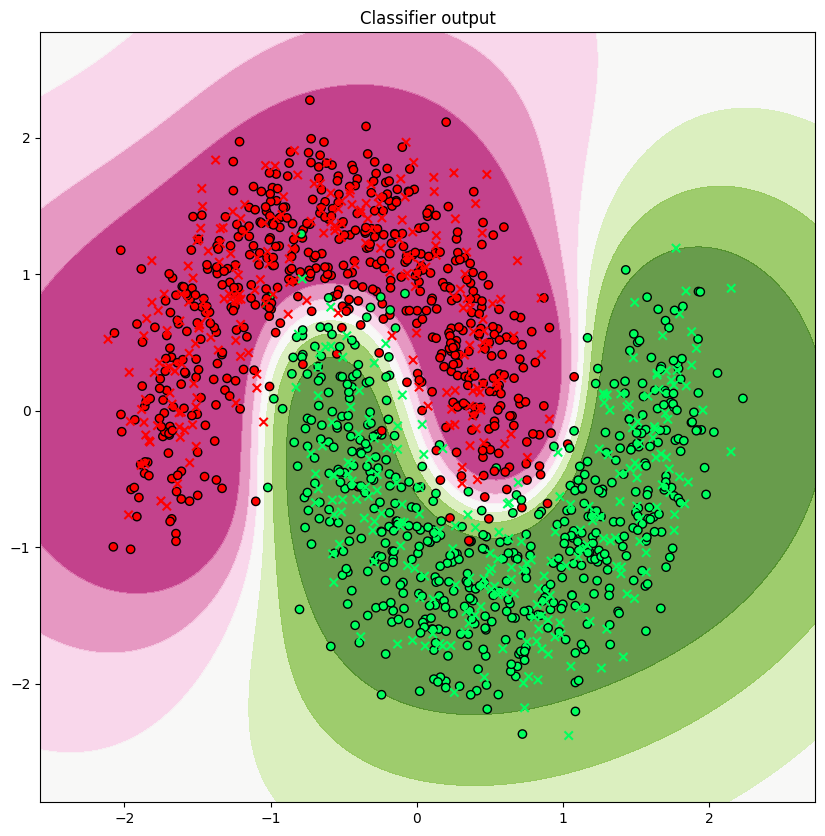

In [5]:
visualizer.plot_training_results(X_train, X_test, y_train, y_test, classifier.clf)

### Run inference on new data

In [6]:
inference_df = data_loader.load_data(inference_file_path)
X_inference = data_loader.transform_data(inference_df)
y_pred = classifier.run_inference(X_inference)
inference_df = inference_df.assign(y_pred=np.round(y_pred, 0))
print(inference_df.head())

2024-06-07 12:55:46,669 - INFO - Data loaded successfully from data/latest_sensor_data.csv
2024-06-07 12:55:46,669 - INFO - Data loaded successfully transformed
2024-06-07 12:55:46,774 - INFO - Inference completed


   sensor_1  sensor_2  y_pred
0  1.662361  0.465601     1.0
1  2.335964  0.670073     1.0
2  1.143369  0.732111     1.0
3  1.629260  1.322346     1.0
4  0.816851  1.795098     0.0


### Interpreting the Graph

The graph you've provided appears to be a decision boundary plot for a classifier, most likely the output from a Gaussian Process Classifier based on your previous context. Here's how you can interpret the various elements of the graph:

#### 1. **Decision Boundary**:
The colored regions in the graph represent the decision boundaries of the classifier. These boundaries separate different predicted classes based on the input features.

- **Purple Region**: Indicates areas where the classifier predicts the negative class with high probability.
- **Green Region**: Indicates areas where the classifier predicts the positive class with high probability.
- **White or Transition Areas**: These areas represent uncertainty, where the classifier is less confident about its predictions, typically around the decision boundary.

#### 2. **Data Points**:
- **Red Crosses (`x`)**: These represent the actual data points that belong to the negative class.
- **Green Crosses (`x`)**: These represent the actual data points that belong to the positive class.
- **Red Circles (`o`)**: These are likely misclassified data points from the negative class.
- **Green Circles (`o`)**: These are likely misclassified data points from the positive class.

#### 3. **Classifier Inference**:
The plot demonstrates the classifier's performance on a given dataset. Here's what to look for:

- **Misclassified Points**: Points that fall in a region not matching their true label color (e.g., a red cross in the green region) indicate misclassifications.
- **Decision Boundary Shape**: The shape and complexity of the boundary can give you insights into how the classifier is generalizing the data. A smooth boundary suggests a simple decision function, while a highly convoluted boundary indicates a more complex model, potentially overfitting.



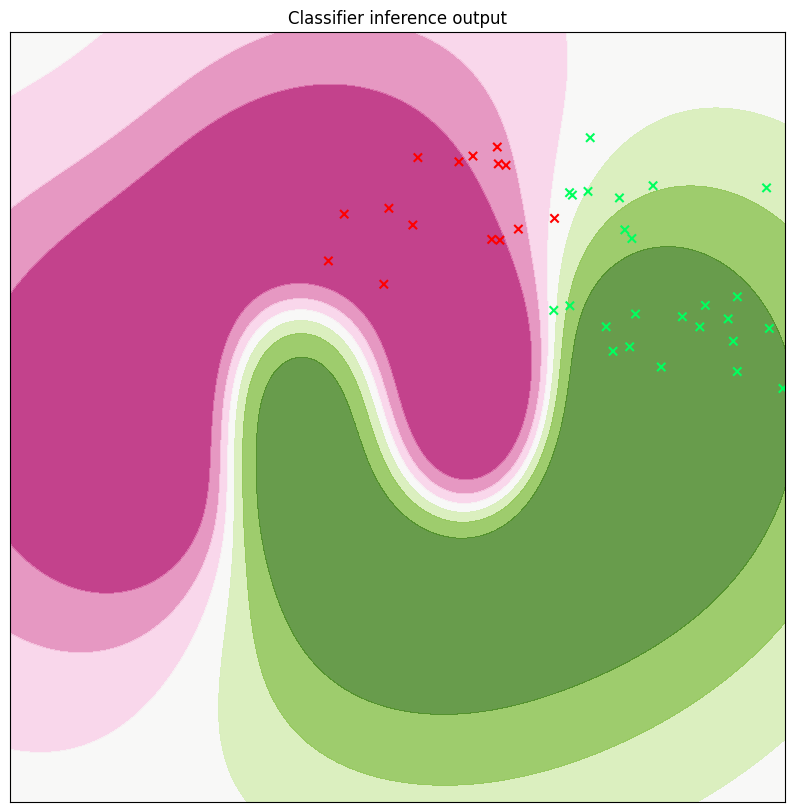

In [18]:
visualizer.plot_inference(X_train, X_inference, y_train, classifier.clf, y_pred)

### save model
model is being saved with a datestamp to a docker volume that is available to the model deployment container. This means that when making requests to the model container, we can specify each model individually and every model that was trained is accessible. 

In [13]:
classifier.save_model(f"{model_folder}/sensor_data_classifier_{Config.timestamp}.pkl")

2024-06-07 13:28:28,924 - INFO - Model saved successfully to models//sensor_data_classifier_2024_06_07.pkl
